In [2]:
import pandas as pd
import numpy as np

# Func to create cohorts and optimize data for analysis
def cohort_import(filepaths):
    all_cohort_data = []  

    
    for filepath in filepaths:
        df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8', on_bad_lines='skip')

        df['review_length'] = df['review_body'].str.len()
        df['star_rating'] = pd.to_numeric(df['star_rating'], errors='coerce')
        df.drop(columns=['marketplace', 'review_body', 'review_headline', 'product_parent', 'total_votes', 'vine'], inplace=True, errors='ignore')
        df['customer_id'] = df['customer_id'].astype('int32', errors='ignore')
        df['product_category'] = df['product_category'].astype('category')
        df['star_rating'] = df['star_rating'].astype('float16')
        df['helpful_votes'] = df['helpful_votes'].astype('float16')
        df['verified_purchase'] = df['verified_purchase'].map({'Y': True, 'N': False}).astype(bool)
        df['review_date'] = pd.to_datetime(df['review_date'], errors='coerce')
        df['verified_percent'] = df['verified_purchase'].map({'Y': 1, 'N': 0})

        # Sort by 'product_id' and 'review_date' to prepare for cohort analysis
        df.sort_values(['product_id', 'review_date'], inplace=True)
        
        df['review_cohort'] = df.groupby('product_id').cumcount() // 100
        cohort_data = df.groupby(['product_id', 'review_cohort']).agg(
            average_rating=('star_rating', 'mean'),
            end_date=('review_date', 'max'),
            mean_review_length=('review_length', 'mean'),
            percent_verified=('verified_percent', 'sum')  
            ).reset_index()
        

        all_cohort_data.append(cohort_data)
    
    df_vol = pd.concat(all_cohort_data, ignore_index=True)
    
    return df_vol

    
    

In [3]:
# Run import and optimize func
df_vol = cohort_import([(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Outdoors_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Furniture_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Automotive_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Major_Appliances_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Office_Products_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Tools_v1_00.tsv"), 
(r"D:\NYCDSA REVIEWS PROJECT\AMZN_Reviews\amazon_reviews_us_Camera_v1_00.tsv")])

C:\Users\willf\AppData\Local\Temp\ipykernel_10200\2394030453.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8', on_bad_lines='skip')
C:\Users\willf\AppData\Local\Temp\ipykernel_10200\2394030453.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8', on_bad_lines='skip')
C:\Users\willf\AppData\Local\Temp\ipykernel_10200\2394030453.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8', on_bad_lines='skip')
C:\Users\willf\AppData\Local\Temp\ipykernel_10200\2394030453.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath, sep='\t', encoding = 'utf-8', on_bad_lines='skip')


In [4]:

# Inspect a few products to make sure things worked
sample_product_ids = df_vol['product_id'].sample(n=3, random_state=1).tolist()

for product_id in sample_product_ids:
    product_data = df_vol[df_vol['product_id'] == product_id]
    print(f"Data for product {product_id}:")
    print(product_data)
    print("\n")


Data for product B00ELR5LKW:
        product_id  review_cohort  average_rating   end_date  \
508016  B00ELR5LKW              0             4.0 2014-10-25   

        mean_review_length  percent_verified  
508016          136.714286               0.0  


Data for product B00LCMBFL8:
        product_id  review_cohort  average_rating   end_date  \
349650  B00LCMBFL8              0             4.0 2015-07-25   

        mean_review_length  percent_verified  
349650                27.0               0.0  


Data for product B00K805UWA:
        product_id  review_cohort  average_rating   end_date  \
338882  B00K805UWA              0             1.0 2015-07-10   

        mean_review_length  percent_verified  
338882                64.5               0.0  




In [5]:
# More inspection since this func caused me lots of problems in previous iterations
# Also filtering for min amount of cohorts

print(f'df_vol rows: {df_vol.shape[0]}')

# Count cohorts for each product
cohort_counts = df_vol.groupby('product_id')['review_cohort'].nunique()
print(cohort_counts.head())

# Filter out < 4 cohort products
products_with_four_cohorts = cohort_counts[cohort_counts >= 4].index
filtered_cohort_data = df_vol[df_vol['product_id'].isin(products_with_four_cohorts)]

print(filtered_cohort_data.shape[0])

df_vol rows: 2007212
product_id
0006446256    1
0007262973    1
0011300000    1
0113000316    1
0136039847    1
Name: review_cohort, dtype: int64
21624


In [6]:
# Test that filtering worked
cohort_counts = filtered_cohort_data.groupby('product_id')['review_cohort'].nunique()
print(cohort_counts.describe())
assert cohort_counts.min() >= 4, "There are products with fewer than 5 cohorts in the dataset."


count    3355.000000
mean        6.442921
std         4.854589
min         4.000000
25%         4.000000
50%         5.000000
75%         7.000000
max        94.000000
Name: review_cohort, dtype: float64


In [7]:
# Repeat product inspection
sample_product_ids = filtered_cohort_data['product_id'].sample(n=3, random_state=1).tolist()

for product_id in sample_product_ids:
    product_data = filtered_cohort_data[filtered_cohort_data['product_id'] == product_id]
    print(f"Data for product {product_id}:")
    print(product_data)
    print("\n")


Data for product B0026ICM1E:
         product_id  review_cohort  average_rating   end_date  \
1395755  B0026ICM1E              0        4.171875 2012-07-31   
1395756  B0026ICM1E              1        4.238281 2013-04-04   
1395757  B0026ICM1E              2        4.179688 2013-12-17   
1395758  B0026ICM1E              3        4.421875 2014-10-27   
1395759  B0026ICM1E              4        4.531250 2015-05-29   
1395760  B0026ICM1E              5        4.542969 2015-08-31   

         mean_review_length  percent_verified  
1395755          616.120000               0.0  
1395756          439.000000               0.0  
1395757          409.320000               0.0  
1395758          327.860000               0.0  
1395759          198.010000               0.0  
1395760          195.391304               0.0  


Data for product B00BOXNSRY:
         product_id  review_cohort  average_rating   end_date  \
1534933  B00BOXNSRY              0        4.578125 2014-09-14   
1534934  B00BOXNSR

In [8]:
# Check that NaN values in rating changes are correct (should be one for each product)
data_for_volatility_analysis = filtered_cohort_data.copy()

data_for_volatility_analysis['rating_change'] = data_for_volatility_analysis.groupby('product_id')['average_rating'].diff().abs()

nan_counts = data_for_volatility_analysis['rating_change'].isna().groupby(data_for_volatility_analysis['product_id']).sum()

print(f"Total NaN values (should be equal to the number of products): {nan_counts.sum()}")

# Drop  NaN values
data_for_volatility_analysis.dropna(subset=['rating_change'], inplace=True)


Total NaN values (should be equal to the number of products): 3355


In [9]:
# More testing - looking at an example product's cohorts and avg ratings per cohort
example_product_id = filtered_cohort_data['product_id'].iloc[0]
example_product_data = filtered_cohort_data[filtered_cohort_data['product_id'] == example_product_id]
print(example_product_data[['product_id', 'review_cohort', 'average_rating']])


     product_id  review_cohort  average_rating
211  B00004YVB2              0        4.718750
212  B00004YVB2              1        4.539062
213  B00004YVB2              2        4.699219
214  B00004YVB2              3        4.558594
215  B00004YVB2              4        4.628906
216  B00004YVB2              5        4.699219
217  B00004YVB2              6        4.699219
218  B00004YVB2              7        4.761719


In [10]:
# Calc avg volatility across all products
average_volatility = data_for_volatility_analysis['rating_change'].mean()

print(f"The average volatility across all products is {average_volatility:.2f} stars.")
data_for_volatility_analysis.shape[0]

The average volatility across all products is 0.17 stars.


18269

In [11]:
# Calc mean volatility per product
per_product_volatility = data_for_volatility_analysis.groupby('product_id')['rating_change'].mean()

# Avg across products
average_volatility = per_product_volatility.mean()

print(f"The average of per-product volatility across all products is {average_volatility:.2f} stars.")


The average of per-product volatility across all products is 0.19 stars.


In [12]:
# Calc 25th and 75th percentiles for volatility and identify high and low volatility products. Then check avg cohorts for each.
volatility_25th_percentile = per_product_volatility.quantile(0.25)
volatility_75th_percentile = per_product_volatility.quantile(0.75)

high_volatility_products = per_product_volatility[per_product_volatility > volatility_75th_percentile].index
low_volatility_products = per_product_volatility[per_product_volatility < volatility_25th_percentile].index

# Filter original DF to only high and low volatility products
high_vol_df = data_for_volatility_analysis[data_for_volatility_analysis['product_id'].isin(high_volatility_products)]
low_vol_df = data_for_volatility_analysis[data_for_volatility_analysis['product_id'].isin(low_volatility_products)]

# Calculate the average number of cohorts for high and low volatility products
average_cohorts_high_vol = high_vol_df.groupby('product_id')['review_cohort'].nunique().mean()
average_cohorts_low_vol = low_vol_df.groupby('product_id')['review_cohort'].nunique().mean()

print(f"Average number of cohorts for high volatility products: {average_cohorts_high_vol:.2f}")
print(f"Average number of cohorts for low volatility products: {average_cohorts_low_vol:.2f}")


Average number of cohorts for high volatility products: 4.45
Average number of cohorts for low volatility products: 5.36


In [13]:
# Calc avg volatility for all, high-vol and low-vol 
average_volatility = per_product_volatility.mean()

average_volatility_high_filtered = per_product_volatility.loc[high_volatility_products].mean()

average_volatility_low_filtered = per_product_volatility.loc[low_volatility_products].mean()

print(f"Average volatility across all products with at least 4 cohorts: {average_volatility:.2f} stars")
print(f"Average volatility for high volatility products with at least 4 cohorts: {average_volatility_high_filtered:.2f} stars")
print(f"Average volatility for low volatility products with at least 4 cohorts: {average_volatility_low_filtered:.2f} stars")


Average volatility across all products with at least 4 cohorts: 0.19 stars
Average volatility for high volatility products with at least 4 cohorts: 0.35 stars
Average volatility for low volatility products with at least 4 cohorts: 0.07 stars


In [14]:
# See if there is a general trend in the direction and amount of rating changes from one cohort to the next

from scipy.stats import linregress

# Func to calc slope of avg rating
def calculate_slope(group):
    regression_results = linregress(group['review_cohort'], group['average_rating'])
    return regression_results.slope

# Apply func to each product
slopes = data_for_volatility_analysis.groupby('product_id').apply(calculate_slope)

# Calc overall rating range from max rating to min rating per product
rating_range = data_for_volatility_analysis.groupby('product_id')['average_rating'].agg(lambda x: x.max() - x.min())

# Create slope and range per product DF
trend_analysis = pd.DataFrame({
    'slope': slopes,
    'rating_range': rating_range
})

# Look at trends for all products
general_trend = 'Increasing' if trend_analysis['slope'].mean() > 0 else 'Decreasing'

print(f"The general trend in average ratings over time is: {general_trend}")

print(f"The average range of average ratings across all products is: {trend_analysis['rating_range'].mean():.2f} stars")


c:\Users\willf\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The general trend in average ratings over time is: Increasing
The average range of average ratings across all products is: 0.42 stars


In [15]:
# Line plot of avg rating per cohort for high vs low-vol products

# Calc avg rating per cohort for high vol and low vol
high_vol_avg_rating_by_cohort = high_vol_df.groupby('review_cohort')['average_rating'].mean()

low_vol_avg_rating_by_cohort = low_vol_df.groupby('review_cohort')['average_rating'].mean()

# Plot
plt.figure(figsize=(14, 7))

plt.plot(high_vol_avg_rating_by_cohort.index, high_vol_avg_rating_by_cohort.values, label='High Volatility', marker='o')
plt.plot(low_vol_avg_rating_by_cohort.index, low_vol_avg_rating_by_cohort.values, label='Low Volatility', marker='x')

plt.title('Average Rating Trajectory Over Time')
plt.xlabel('Cohort Number')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)

plt.show()


NameError: name 'plt' is not defined

In [16]:
# Seeing the fall off in the avg rating, I wondered if that was due to the sample size of products in each cohort falling

# Count products for each high-vol cohort
high_vol_product_count_by_cohort = high_vol_df.groupby('review_cohort')['product_id'].nunique()

product_count_around_25th_cohort = high_vol_product_count_by_cohort.loc[20:30]
print(product_count_around_25th_cohort)


review_cohort
20    7
21    5
22    4
23    4
24    3
25    2
26    2
27    2
28    2
29    2
30    2
Name: product_id, dtype: int64


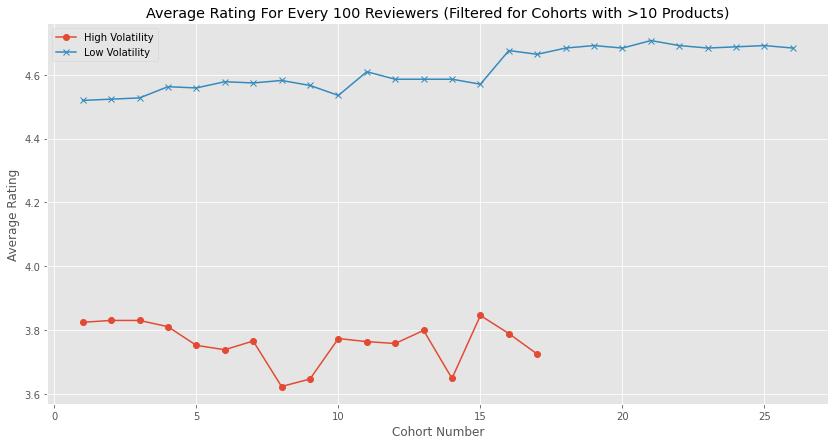

In [19]:
# Re-plotting with floor on products per cohort 

import matplotlib.pyplot as plt

plt.style.use("ggplot")

high_vol_avg_rating_by_cohort = high_vol_df.groupby('review_cohort')['average_rating'].mean()

low_vol_avg_rating_by_cohort = low_vol_df.groupby('review_cohort')['average_rating'].mean()

high_vol_product_count_by_cohort = high_vol_df.groupby('review_cohort')['product_id'].nunique()

low_vol_product_count_by_cohort = low_vol_df.groupby('review_cohort')['product_id'].nunique()

# Filter cohorts to only include those with 10 or more products
high_vol_avg_rating_by_cohort_filtered = high_vol_avg_rating_by_cohort[high_vol_product_count_by_cohort >= 10]
low_vol_avg_rating_by_cohort_filtered = low_vol_avg_rating_by_cohort[low_vol_product_count_by_cohort >= 10]

# Plot
plt.figure(figsize=(14, 7))
plt.plot(high_vol_avg_rating_by_cohort_filtered.index, high_vol_avg_rating_by_cohort_filtered.values, label='High Volatility', marker='o')
plt.plot(low_vol_avg_rating_by_cohort_filtered.index, low_vol_avg_rating_by_cohort_filtered.values, label='Low Volatility', marker='x')

plt.title('Average Rating For Every 100 Reviewers (Filtered for Cohorts with >10 Products)')
plt.xlabel('Cohort Number')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)
plt.show()


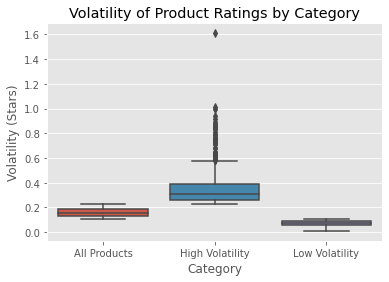

In [21]:
# Plot high, low, all products as boxplit
import seaborn as sns

volatility_data = per_product_volatility.reset_index()
volatility_data.columns = ['product_id', 'volatility']

volatility_data['category'] = 'All Products'  
volatility_data.loc[volatility_data['product_id'].isin(high_volatility_products), 'category'] = 'High Volatility'
volatility_data.loc[volatility_data['product_id'].isin(low_volatility_products), 'category'] = 'Low Volatility'


sns.boxplot(x='category', y='volatility', data=volatility_data)
plt.title('Volatility of Product Ratings by Category')
plt.xlabel('Category')
plt.ylabel('Volatility (Stars)')
plt.show()


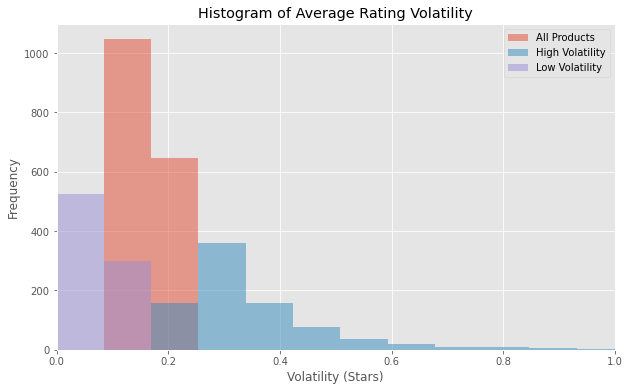

In [22]:
# Plot as histograms

bins = np.linspace(0, volatility_data['volatility'].max(), 20)

plt.figure(figsize=(10, 6))

plt.hist(volatility_data[volatility_data['category'] == 'All Products']['volatility'], bins=bins, alpha=0.5, label='All Products')

plt.hist(volatility_data[volatility_data['category'] == 'High Volatility']['volatility'], bins=bins, alpha=0.5, label='High Volatility')

plt.hist(volatility_data[volatility_data['category'] == 'Low Volatility']['volatility'], bins=bins, alpha=0.5, label='Low Volatility')

plt.title('Histogram of Average Rating Volatility')
plt.xlabel('Volatility (Stars)')
plt.ylabel('Frequency')
plt.xlim(0,1.0)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


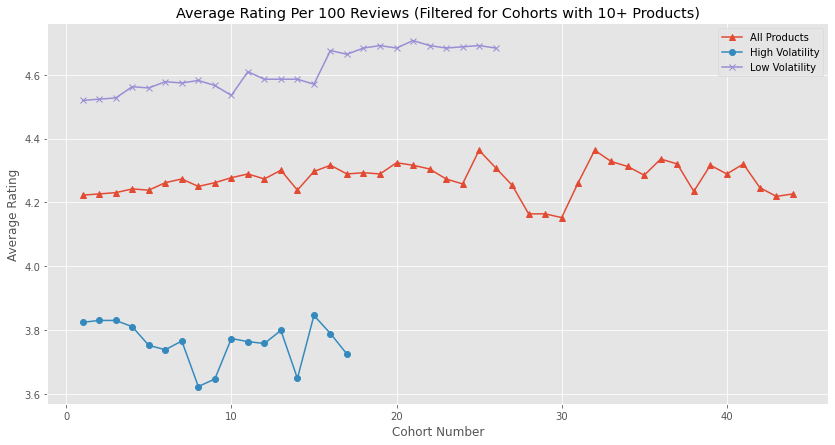

In [23]:
# Line plot of all vs high vs low vol products

all_products_avg_rating_by_cohort = data_for_volatility_analysis.groupby('review_cohort')['average_rating'].mean()
all_products_count_by_cohort = data_for_volatility_analysis.groupby('review_cohort')['product_id'].nunique()
all_products_avg_rating_by_cohort_filtered = all_products_avg_rating_by_cohort[all_products_count_by_cohort >= 10]

# Plot
plt.figure(figsize=(14, 7))

plt.plot(all_products_avg_rating_by_cohort_filtered.index, all_products_avg_rating_by_cohort_filtered.values, label='All Products', marker='^')

plt.plot(high_vol_avg_rating_by_cohort_filtered.index, high_vol_avg_rating_by_cohort_filtered.values, label='High Volatility', marker='o')

plt.plot(low_vol_avg_rating_by_cohort_filtered.index, low_vol_avg_rating_by_cohort_filtered.values, label='Low Volatility', marker='x')

plt.title('Average Rating Per 100 Reviews (Filtered for Cohorts with 10+ Products)')
plt.xlabel('Cohort Number')
plt.ylabel('Average Rating')
plt.legend()
plt.grid(True)

plt.show()
